In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy
from torch.nn import ModuleList

from gpytorch.mlls import VariationalELBO, MarginalLogLikelihood
from gpytorch.utils.generic import length_safe_zip

In [2]:
train_x1 = torch.linspace(0, 0.95, 50) + 0.05 * torch.rand(50)
train_x2 = torch.linspace(0, 0.95, 25) + 0.05 * torch.rand(25)

train_y1 = torch.sin(train_x1 * (2 * math.pi)) + 0.2 * torch.randn_like(train_x1)
train_y2 = torch.cos(train_x2 * (2 * math.pi)) + 0.2 * torch.randn_like(train_x2)

In [3]:
class Variational_GP(ApproximateGP):
    def __init__(self, 
                 inducing_points, 
                 likelihood, 
                 learn_inducing_locations=True,
                 input_dim=1):
        
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=learn_inducing_locations)
        
        super(Variational_GP, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module_input = gpytorch.kernels.RBFKernel(input_dim=input_dim)
        self.likelihood = likelihood

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module_input(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [4]:
num_inducing_1 = 5
num_inducing_2 = 3

inducing_points1 = torch.linspace(0, 0.95, num_inducing_1)
likelihood1 = gpytorch.likelihoods.GaussianLikelihood()

inducing_points2 = torch.linspace(0, 0.95, num_inducing_2)
likelihood2 = gpytorch.likelihoods.GaussianLikelihood()

SVGP_1 = Variational_GP(inducing_points1, likelihood1)
SVGP_2 = Variational_GP(inducing_points2, likelihood2)

In [5]:
model = gpytorch.models.IndependentModelList(*[SVGP_1, SVGP_2])
likelihood = gpytorch.likelihoods.LikelihoodList(*[SVGP_1.likelihood, SVGP_2.likelihood])

In [6]:
# model.models[0].likelihood

In [7]:
class SumVariationalELBO(MarginalLogLikelihood):
    """Sum of variational elbo, to be used with Multi-Output models.

    Args:
        model: A MultiOutputModel
        num_data_list: A List of number of data
        mll_cls: Variational ELBO class

    In case the model outputs are independent, this provives the MLL of the multi-output model.

    """

    def __init__(self, model, num_data_list, mll_cls=VariationalELBO):
        super().__init__(model.likelihood, model)
        self.mlls = ModuleList([mll_cls(mdl.likelihood, mdl, num_data_list[i]) for i, mdl in enumerate(model.models)])

    def forward(self, outputs, targets, *params):
        """
        Args:
            outputs: (Iterable[MultivariateNormal]) - the outputs of the latent function
            targets: (Iterable[Tensor]) - the target values
            params: (Iterable[Iterable[Tensor]]) - the arguments to be passed through
                (e.g. parameters in case of heteroskedastic likelihoods)
        """
        if len(params) == 0:
            sum_mll = sum(mll(output, target) for mll, output, target in length_safe_zip(self.mlls, outputs, targets))
        else:
            sum_mll = sum(
                mll(output, target, *iparams)
                for mll, output, target, iparams in length_safe_zip(self.mlls, outputs, targets, params)
            )
        return sum_mll.div_(len(self.mlls))

In [8]:
num_data_list = [50, 25]
mll = SumVariationalELBO(model, num_data_list)

In [9]:
for name, param in mll.named_parameters():
    print(name)

likelihood.likelihoods.0.noise_covar.raw_noise
likelihood.likelihoods.1.noise_covar.raw_noise
model.models.0.variational_strategy.inducing_points
model.models.0.variational_strategy._variational_distribution.variational_mean
model.models.0.variational_strategy._variational_distribution.chol_variational_covar
model.models.0.covar_module_input.raw_lengthscale
model.models.1.variational_strategy.inducing_points
model.models.1.variational_strategy._variational_distribution.variational_mean
model.models.1.variational_strategy._variational_distribution.chol_variational_covar
model.models.1.covar_module_input.raw_lengthscale


In [10]:
import random

In [11]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 1000


# Find optimal model hyperparameters
model.train()

# Use the Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Includes GaussianLikelihood parameters
mini_batch_size = 5
for i in range(training_iterations):

    output1_idx_list = random.choices(range(50), k=mini_batch_size)
    output2_idx_list = random.choices(range(25), k=mini_batch_size)

    input1 = train_x1[output1_idx_list]
    input2 = train_x2[output2_idx_list]
    input_list = [input1, input2]

    target1 = train_y1[output1_idx_list]
    target2 = train_y2[output2_idx_list]
    target_list = [target1, target2]

    optimizer.zero_grad()
    output = model(*input_list)
    loss = -mll(output, target_list)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

Iter 1/1000 - Loss: 1.927
Iter 2/1000 - Loss: 1.865
Iter 3/1000 - Loss: 1.943
Iter 4/1000 - Loss: 1.776
Iter 5/1000 - Loss: 1.801
Iter 6/1000 - Loss: 1.890
Iter 7/1000 - Loss: 1.690
Iter 8/1000 - Loss: 1.604
Iter 9/1000 - Loss: 1.631
Iter 10/1000 - Loss: 1.636
Iter 11/1000 - Loss: 1.623
Iter 12/1000 - Loss: 1.661
Iter 13/1000 - Loss: 1.686
Iter 14/1000 - Loss: 1.582
Iter 15/1000 - Loss: 1.355
Iter 16/1000 - Loss: 1.421
Iter 17/1000 - Loss: 1.455
Iter 18/1000 - Loss: 1.444
Iter 19/1000 - Loss: 1.713
Iter 20/1000 - Loss: 1.494
Iter 21/1000 - Loss: 1.578
Iter 22/1000 - Loss: 1.493
Iter 23/1000 - Loss: 1.402
Iter 24/1000 - Loss: 1.254
Iter 25/1000 - Loss: 1.455
Iter 26/1000 - Loss: 1.465
Iter 27/1000 - Loss: 1.220
Iter 28/1000 - Loss: 1.362
Iter 29/1000 - Loss: 1.353
Iter 30/1000 - Loss: 1.204
Iter 31/1000 - Loss: 1.374
Iter 32/1000 - Loss: 1.294
Iter 33/1000 - Loss: 1.227
Iter 34/1000 - Loss: 1.405
Iter 35/1000 - Loss: 1.235
Iter 36/1000 - Loss: 1.275
Iter 37/1000 - Loss: 1.269
Iter 38/10

In [12]:
train_x_list = [train_x1, train_x2]
train_y_list = [train_y1, train_y2]

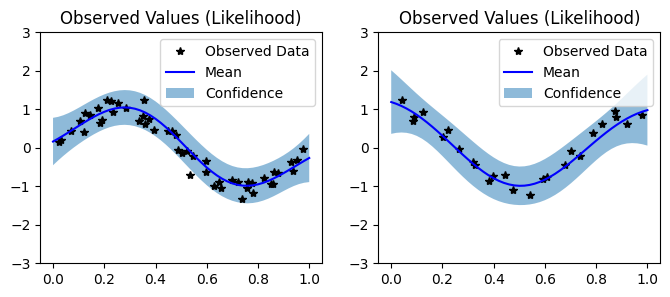

In [13]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
f, axs = plt.subplots(1, 2, figsize=(8, 3))

# Make predictions (use the same test points)
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    # This contains predictions for both outcomes as a list
    predictions = likelihood(*model(test_x, test_x))

for i, submodel, prediction, ax in zip(range(2), model.models, predictions, axs):
    mean = prediction.mean
    lower, upper = prediction.confidence_region()

    # tr_x = submodel.train_inputs[0].detach().numpy()
    # tr_y = submodel.train_targets.detach().numpy()

    tr_x, tr_y = train_x_list[i], train_y_list[i]

    # Plot training data as black stars
    ax.plot(tr_x, tr_y, 'k*')
    # Predictive mean as blue line
    ax.plot(test_x.numpy(), mean.numpy(), 'b')
    # Shade in confidence
    ax.fill_between(test_x.numpy(), lower.detach().numpy(), upper.detach().numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_title('Observed Values (Likelihood)')
